In [37]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import joblib
import optuna
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')


In [6]:
print("--- Initial Data Head ---")
print(df.head())


--- Initial Data Head ---
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingM

In [7]:
print("\n--- Data Info ---")
df.info()


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 

In [8]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df.drop('customerID', axis=1, inplace=True)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [11]:
print(f"\nShape of data after cleaning: {df.shape}")


Shape of data after cleaning: (7032, 20)


In [12]:
# --- 4. Define Features and Target ---
X = df.drop('Churn', axis=1)
y = df['Churn']


In [13]:
# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

In [14]:
print(f"\nCategorical Features: {list(categorical_features)}")
print(f"Numerical Features: {list(numerical_features)}")


Categorical Features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical Features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [15]:
# Create a pipeline for numerical features: scale them
numerical_transformer = StandardScaler()

In [16]:
# Create a pipeline for categorical features: one-hot encode them
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [17]:
# Create a preprocessor object using ColumnTransformer to 
# apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

In [31]:
print("\n--- Starting Hyperparameter Tuning with Optuna ---")

# Calculate scale_pos_weight once
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

def objective(trial):
    """Define the objective function for Optuna to optimize."""
    # Define the search space for hyperparameters
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'random_state': 42,
        'scale_pos_weight': scale_pos_weight
    }

    # Create a pipeline with the suggested hyperparameters
    model = lgb.LGBMClassifier(**params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    # Train and evaluate the model
    pipeline.fit(X_train, y_train)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return auc

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 trials

print(f"Best trial found: {study.best_trial.number}")
print(f"Best ROC AUC: {study.best_value:.4f}")
print("Best hyperparameters:", study.best_params)

[I 2025-08-17 17:41:43,450] A new study created in memory with name: no-name-ebd5b176-7e6b-4136-8fbc-2374f96f284e



--- Starting Hyperparameter Tuning with Optuna ---
[LightGBM] [Warning] lambda_l1 is set=1.2377168497192437e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2377168497192437e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.00042897790236042736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00042897790236042736
[LightGBM] [Warning] bagging_fraction is set=0.5236249290628586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5236249290628586
[LightGBM] [Warning] feature_fraction is set=0.9823004488428994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9823004488428994
[LightGBM] [Warning] lambda_l1 is set=1.2377168497192437e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2377168497192437e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightG

[I 2025-08-17 17:41:43,766] Trial 0 finished with value: 0.810471033436696 and parameters: {'n_estimators': 454, 'learning_rate': 0.2023146801651128, 'num_leaves': 163, 'max_depth': 3, 'min_child_samples': 77, 'feature_fraction': 0.9823004488428994, 'bagging_fraction': 0.5236249290628586, 'bagging_freq': 2, 'lambda_l1': 1.2377168497192437e-06, 'lambda_l2': 0.00042897790236042736}. Best is trial 0 with value: 0.810471033436696.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:41:44,226] Trial 1 finished with value: 0.8084728038887825 and parameters: {'n_estimators': 724, 'learning_rate': 0.13381520331873525, 'num_leaves': 90, 'max_depth': 3, 'min_child_samples': 17, 'feature_fraction': 0.41686992030665126, 'bagging_fraction': 0.5287627290192917, 'bagging_freq': 4, 'lambda_l1': 0.00016760359607990435, 'lambda_l2': 4.8611391660998134e-05}. Best is trial 0 with value: 0.810471033436696.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:41:45,980] Trial 2 finished with value: 0.8176421409010668 and parameters: {'n_estimators': 616, 'learning_rate': 0.0374779323589269, 'num_leaves': 200, 'max_depth': 12, 'min_child_samples': 88, 'feature_fraction': 0.7654663195149325, 'bagging_fraction': 0.8038616189684092, 'bagging_freq': 1, 'lambda_l1': 8.405244691969373e-05, 'lambda_l2': 0.06775293654209046}. Best is trial 2 with value: 0.8176421409010668.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:41:46,166] Trial 3 finished with value: 0.8219466172458598 and parameters: {'n_estimators': 117, 'learning_rate': 0.24487371749388157, 'num_leaves': 40, 'max_depth': 5, 'min_child_samples': 39, 'feature_fraction': 0.45662053619743415, 'bagging_fraction': 0.4112616374558794, 'bagging_freq': 1, 'lambda_l1': 2.0339946981169583, 'lambda_l2': 0.008141119259564435}. Best is trial 3 with value: 0.8219466172458598.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:41:48,904] Trial 4 finished with value: 0.8022102178898488 and parameters: {'n_estimators': 896, 'learning_rate': 0.06357581370588591, 'num_leaves': 162, 'max_depth': 7, 'min_child_samples': 25, 'feature_fraction': 0.5069392289384989, 'bagging_fraction': 0.8114967435743545, 'bagging_freq': 5, 'lambda_l1': 0.018568672236123254, 'lambda_l2': 1.275155977179296e-06}. Best is trial 3 with value: 0.8219466172458598.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:41:50,357] Trial 5 finished with value: 0.7917479849459805 and parameters: {'n_estimators': 735, 'learning_rate': 0.2508539513138995, 'num_leaves': 74, 'max_depth': 7, 'min_child_samples': 94, 'feature_fraction': 0.5086152466872275, 'bagging_fraction': 0.8871384459192029, 'bagging_freq': 4, 'lambda_l1': 5.1181682895548795e-06, 'lambda_l2': 8.433795829465239e-05}. Best is trial 3 with value: 0.8219466172458598.


[LightGBM] [Warning] lambda_l1 is set=5.1181682895548795e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1181682895548795e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5086152466872275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5086152466872275
[LightGBM] [Warning] bagging_fraction is set=0.8871384459192029, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8871384459192029
[LightGBM] [Warning] lambda_l2 is set=8.433795829465239e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.433795829465239e-05
[LightGBM] [Warning] lambda_l1 is set=2.187034696310401e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.187034696310401e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.37307975786210046, reg_

[I 2025-08-17 17:41:52,183] Trial 6 finished with value: 0.7847541815282832 and parameters: {'n_estimators': 978, 'learning_rate': 0.2311091972161803, 'num_leaves': 30, 'max_depth': 7, 'min_child_samples': 60, 'feature_fraction': 0.7296415071723937, 'bagging_fraction': 0.5093470302475681, 'bagging_freq': 4, 'lambda_l1': 2.187034696310401e-05, 'lambda_l2': 0.37307975786210046}. Best is trial 3 with value: 0.8219466172458598.


[LightGBM] [Warning] lambda_l1 is set=0.00018193357516672678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018193357516672678
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0012724574480265254, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012724574480265254
[LightGBM] [Warning] bagging_fraction is set=0.8032990129820479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8032990129820479
[LightGBM] [Warning] feature_fraction is set=0.6865029128662324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6865029128662324
[LightGBM] [Warning] lambda_l1 is set=0.00018193357516672678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018193357516672678
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0012724574480265254, 

[I 2025-08-17 17:41:54,792] Trial 7 finished with value: 0.7889784180855306 and parameters: {'n_estimators': 539, 'learning_rate': 0.2102120864114544, 'num_leaves': 159, 'max_depth': 11, 'min_child_samples': 37, 'feature_fraction': 0.6865029128662324, 'bagging_fraction': 0.8032990129820479, 'bagging_freq': 5, 'lambda_l1': 0.00018193357516672678, 'lambda_l2': 0.0012724574480265254}. Best is trial 3 with value: 0.8219466172458598.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:41:58,385] Trial 8 finished with value: 0.7920560021949465 and parameters: {'n_estimators': 659, 'learning_rate': 0.09605278615323515, 'num_leaves': 72, 'max_depth': 11, 'min_child_samples': 13, 'feature_fraction': 0.8395537856655363, 'bagging_fraction': 0.586468733064035, 'bagging_freq': 1, 'lambda_l1': 0.5868434417297272, 'lambda_l2': 0.008219261570501308}. Best is trial 3 with value: 0.8219466172458598.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.5868434417297272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5868434417297272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM

[I 2025-08-17 17:41:58,886] Trial 9 finished with value: 0.8019746752876984 and parameters: {'n_estimators': 261, 'learning_rate': 0.26967678015270863, 'num_leaves': 300, 'max_depth': 6, 'min_child_samples': 55, 'feature_fraction': 0.5993437876297286, 'bagging_fraction': 0.6898906223553394, 'bagging_freq': 5, 'lambda_l1': 1.3233504306314314, 'lambda_l2': 0.021312760679676614}. Best is trial 3 with value: 0.8219466172458598.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:41:59,051] Trial 10 finished with value: 0.823467290638864 and parameters: {'n_estimators': 101, 'learning_rate': 0.29504148732527435, 'num_leaves': 20, 'max_depth': 5, 'min_child_samples': 39, 'feature_fraction': 0.4121211839471899, 'bagging_fraction': 0.9839077723340424, 'bagging_freq': 7, 'lambda_l1': 0.009612307523926581, 'lambda_l2': 9.660126526619536}. Best is trial 10 with value: 0.823467290638864.


[LightGBM] [Warning] lambda_l1 is set=0.009612307523926581, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009612307523926581
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=9.660126526619536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.660126526619536
[LightGBM] [Warning] bagging_fraction is set=0.9839077723340424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9839077723340424
[LightGBM] [Warning] feature_fraction is set=0.4121211839471899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4121211839471899
[LightGBM] [Warning] lambda_l1 is set=0.009612307523926581, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009612307523926581
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=9.660126526619536, reg_lambda=0.0 will 

[I 2025-08-17 17:41:59,226] Trial 11 finished with value: 0.8230207950468756 and parameters: {'n_estimators': 106, 'learning_rate': 0.2675457898805854, 'num_leaves': 22, 'max_depth': 5, 'min_child_samples': 39, 'feature_fraction': 0.4206345031255827, 'bagging_fraction': 0.9744780453025415, 'bagging_freq': 7, 'lambda_l1': 0.020163075290147135, 'lambda_l2': 7.807067123756519}. Best is trial 10 with value: 0.823467290638864.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:41:59,400] Trial 12 finished with value: 0.8184743051493236 and parameters: {'n_estimators': 111, 'learning_rate': 0.29976044532164653, 'num_leaves': 21, 'max_depth': 5, 'min_child_samples': 41, 'feature_fraction': 0.5780196996830083, 'bagging_fraction': 0.98897440703531, 'bagging_freq': 7, 'lambda_l1': 0.012258733812746897, 'lambda_l2': 3.6429355878801513}. Best is trial 10 with value: 0.823467290638864.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:00,349] Trial 13 finished with value: 0.7992853482147942 and parameters: {'n_estimators': 324, 'learning_rate': 0.2984337125937864, 'num_leaves': 101, 'max_depth': 9, 'min_child_samples': 67, 'feature_fraction': 0.40035948781517294, 'bagging_fraction': 0.9797060862285166, 'bagging_freq': 7, 'lambda_l1': 2.379257229307042e-08, 'lambda_l2': 3.5345549775474208}. Best is trial 10 with value: 0.823467290638864.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=2.379257229307042e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.379257229307042e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.40035948781517294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40035948781517294
[LightGBM] [Warning] bagging_fraction is set=0.9797060862285166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9797060862285166
[LightGBM] [Warning] lambda_l2 is set=3.5345549775474208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5345549775474208
[LightGBM] [Warning] lambda_l1 is set=0.012124651300356674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012124651300356674
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_fre

[I 2025-08-17 17:42:00,629] Trial 14 finished with value: 0.8183888886012911 and parameters: {'n_estimators': 264, 'learning_rate': 0.1829992254194888, 'num_leaves': 121, 'max_depth': 4, 'min_child_samples': 29, 'feature_fraction': 0.5974921374187618, 'bagging_fraction': 0.9087584251060125, 'bagging_freq': 6, 'lambda_l1': 0.012124651300356674, 'lambda_l2': 1.0727768314952855e-08}. Best is trial 10 with value: 0.823467290638864.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:01,962] Trial 15 finished with value: 0.7978177366167799 and parameters: {'n_estimators': 380, 'learning_rate': 0.15277632766577454, 'num_leaves': 249, 'max_depth': 9, 'min_child_samples': 49, 'feature_fraction': 0.5183988969330315, 'bagging_fraction': 0.8920471351145206, 'bagging_freq': 7, 'lambda_l1': 0.0815692885191368, 'lambda_l2': 0.4941905257515421}. Best is trial 10 with value: 0.823467290638864.


[LightGBM] [Warning] lambda_l1 is set=0.0815692885191368, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0815692885191368
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5183988969330315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5183988969330315
[LightGBM] [Warning] bagging_fraction is set=0.8920471351145206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8920471351145206
[LightGBM] [Warning] lambda_l2 is set=0.4941905257515421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4941905257515421
[LightGBM] [Warning] lambda_l1 is set=0.001307736408135959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001307736408135959
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.4838292773412089, reg_lambda=0.0 will b

[I 2025-08-17 17:42:02,289] Trial 16 finished with value: 0.8004216471416516 and parameters: {'n_estimators': 181, 'learning_rate': 0.2735870875426208, 'num_leaves': 56, 'max_depth': 5, 'min_child_samples': 9, 'feature_fraction': 0.6690922299495139, 'bagging_fraction': 0.6609735392580245, 'bagging_freq': 6, 'lambda_l1': 0.001307736408135959, 'lambda_l2': 0.4838292773412089}. Best is trial 10 with value: 0.823467290638864.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:02,516] Trial 17 finished with value: 0.8224189966402825 and parameters: {'n_estimators': 206, 'learning_rate': 0.18871659844419292, 'num_leaves': 130, 'max_depth': 4, 'min_child_samples': 25, 'feature_fraction': 0.8701757164201626, 'bagging_fraction': 0.9344616752097527, 'bagging_freq': 6, 'lambda_l1': 0.001670597601290643, 'lambda_l2': 9.212002463779099}. Best is trial 10 with value: 0.823467290638864.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:03,918] Trial 18 finished with value: 0.7876065765565224 and parameters: {'n_estimators': 432, 'learning_rate': 0.27940053749411764, 'num_leaves': 52, 'max_depth': 9, 'min_child_samples': 47, 'feature_fraction': 0.4515075167453645, 'bagging_fraction': 0.7479344370172111, 'bagging_freq': 3, 'lambda_l1': 0.18557646380094653, 'lambda_l2': 3.899204110762912e-06}. Best is trial 10 with value: 0.823467290638864.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:04,137] Trial 19 finished with value: 0.8280176631067808 and parameters: {'n_estimators': 101, 'learning_rate': 0.11628257724665607, 'num_leaves': 216, 'max_depth': 6, 'min_child_samples': 69, 'feature_fraction': 0.5448071075731513, 'bagging_fraction': 0.999004103414072, 'bagging_freq': 6, 'lambda_l1': 0.0018225837772434855, 'lambda_l2': 0.11478664431581652}. Best is trial 19 with value: 0.8280176631067808.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:04,687] Trial 20 finished with value: 0.8288032365106563 and parameters: {'n_estimators': 338, 'learning_rate': 0.10823456495056592, 'num_leaves': 220, 'max_depth': 8, 'min_child_samples': 74, 'feature_fraction': 0.565158462233228, 'bagging_fraction': 0.859543742290712, 'bagging_freq': 6, 'lambda_l1': 9.612327150008314, 'lambda_l2': 0.12306077418790344}. Best is trial 20 with value: 0.8288032365106563.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:05,236] Trial 21 finished with value: 0.8186658452873361 and parameters: {'n_estimators': 301, 'learning_rate': 0.10742267433021045, 'num_leaves': 230, 'max_depth': 6, 'min_child_samples': 76, 'feature_fraction': 0.550867399279027, 'bagging_fraction': 0.8644087805411738, 'bagging_freq': 6, 'lambda_l1': 0.001666565612043922, 'lambda_l2': 0.09418402093945212}. Best is trial 20 with value: 0.8288032365106563.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lamb

[I 2025-08-17 17:42:05,770] Trial 22 finished with value: 0.8226791288547453 and parameters: {'n_estimators': 215, 'learning_rate': 0.09035339543132781, 'num_leaves': 218, 'max_depth': 8, 'min_child_samples': 69, 'feature_fraction': 0.6546837617881719, 'bagging_fraction': 0.9992222974618951, 'bagging_freq': 6, 'lambda_l1': 1.897613964164821e-07, 'lambda_l2': 0.9529249295650358}. Best is trial 20 with value: 0.8288032365106563.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:06,083] Trial 23 finished with value: 0.8386559059072013 and parameters: {'n_estimators': 168, 'learning_rate': 0.01278870584404554, 'num_leaves': 271, 'max_depth': 8, 'min_child_samples': 83, 'feature_fraction': 0.6335148743594806, 'bagging_fraction': 0.9405712890572046, 'bagging_freq': 5, 'lambda_l1': 9.454043216425049, 'lambda_l2': 0.07437679260840438}. Best is trial 23 with value: 0.8386559059072013.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:06,832] Trial 24 finished with value: 0.8367417987171987 and parameters: {'n_estimators': 359, 'learning_rate': 0.02255606028052585, 'num_leaves': 282, 'max_depth': 8, 'min_child_samples': 87, 'feature_fraction': 0.6300269184969111, 'bagging_fraction': 0.8411074563914815, 'bagging_freq': 5, 'lambda_l1': 5.74673637541964, 'lambda_l2': 0.0019453390881162662}. Best is trial 23 with value: 0.8386559059072013.


[LightGBM] [Warning] lambda_l1 is set=5.74673637541964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.74673637541964
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6300269184969111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6300269184969111
[LightGBM] [Warning] bagging_fraction is set=0.8411074563914815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8411074563914815
[LightGBM] [Warning] lambda_l2 is set=0.0019453390881162662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019453390881162662
[LightGBM] [Warning] lambda_l1 is set=8.11635859136798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.11635859136798
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.002521326197998859, reg_lambda=0.0 will be ig

[I 2025-08-17 17:42:07,746] Trial 25 finished with value: 0.838266354680568 and parameters: {'n_estimators': 508, 'learning_rate': 0.01937259925999832, 'num_leaves': 287, 'max_depth': 8, 'min_child_samples': 99, 'feature_fraction': 0.6433845885296752, 'bagging_fraction': 0.8435835992918481, 'bagging_freq': 5, 'lambda_l1': 8.11635859136798, 'lambda_l2': 0.002521326197998859}. Best is trial 23 with value: 0.8386559059072013.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:08,641] Trial 26 finished with value: 0.8348186321963442 and parameters: {'n_estimators': 530, 'learning_rate': 0.0294512748333192, 'num_leaves': 296, 'max_depth': 10, 'min_child_samples': 100, 'feature_fraction': 0.6269803642622048, 'bagging_fraction': 0.7313089466720869, 'bagging_freq': 5, 'lambda_l1': 7.33896754325342, 'lambda_l2': 0.0013566481568063659}. Best is trial 23 with value: 0.8386559059072013.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:09,900] Trial 27 finished with value: 0.8361801202043786 and parameters: {'n_estimators': 462, 'learning_rate': 0.011325271999317774, 'num_leaves': 266, 'max_depth': 8, 'min_child_samples': 84, 'feature_fraction': 0.7452124067176373, 'bagging_fraction': 0.8311238063646944, 'bagging_freq': 3, 'lambda_l1': 0.2561927847405564, 'lambda_l2': 0.003298101803472727}. Best is trial 23 with value: 0.8386559059072013.


[LightGBM] [Warning] lambda_l1 is set=0.2561927847405564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2561927847405564
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7452124067176373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7452124067176373
[LightGBM] [Warning] bagging_fraction is set=0.8311238063646944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8311238063646944
[LightGBM] [Warning] lambda_l2 is set=0.003298101803472727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003298101803472727
[LightGBM] [Warning] lambda_l1 is set=2.5463126608416395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5463126608416395
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00011167156333631978, reg_lambda=0.0 wi

[I 2025-08-17 17:42:11,011] Trial 28 finished with value: 0.8221821598480102 and parameters: {'n_estimators': 380, 'learning_rate': 0.0641171667242274, 'num_leaves': 275, 'max_depth': 10, 'min_child_samples': 86, 'feature_fraction': 0.8091706107734007, 'bagging_fraction': 0.9279089541903041, 'bagging_freq': 3, 'lambda_l1': 2.5463126608416395, 'lambda_l2': 0.00011167156333631978}. Best is trial 23 with value: 0.8386559059072013.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:12,147] Trial 29 finished with value: 0.8174868380864622 and parameters: {'n_estimators': 470, 'learning_rate': 0.060351118402962055, 'num_leaves': 267, 'max_depth': 10, 'min_child_samples': 99, 'feature_fraction': 0.6395406316441744, 'bagging_fraction': 0.7500334123980007, 'bagging_freq': 5, 'lambda_l1': 0.09432902196560111, 'lambda_l2': 9.846381719152054e-06}. Best is trial 23 with value: 0.8386559059072013.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.09432902196560111, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09432902196560111
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6395406316441744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6395406316441744
[LightGBM] [Warning] bagging_fraction is set=0.7500334123980007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7500334123980007
[LightGBM] [Warning] lambda_l2 is set=9.846381719152054e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.846381719152054e-06
[LightGBM] [Warning] lambda_l1 is set=9.285978791471162, reg_alpha=0.0 will be ignored. Cur

[I 2025-08-17 17:42:13,508] Trial 30 finished with value: 0.8378366835601617 and parameters: {'n_estimators': 617, 'learning_rate': 0.018603618130637954, 'num_leaves': 182, 'max_depth': 9, 'min_child_samples': 82, 'feature_fraction': 0.9687527727485028, 'bagging_fraction': 0.9357397330192835, 'bagging_freq': 4, 'lambda_l1': 9.285978791471162, 'lambda_l2': 0.0006517263057039999}. Best is trial 23 with value: 0.8386559059072013.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:14,927] Trial 31 finished with value: 0.8391489923435712 and parameters: {'n_estimators': 619, 'learning_rate': 0.012912783456967385, 'num_leaves': 189, 'max_depth': 9, 'min_child_samples': 92, 'feature_fraction': 0.9965093115527092, 'bagging_fraction': 0.9348187944747812, 'bagging_freq': 4, 'lambda_l1': 8.356439351497064, 'lambda_l2': 0.00041318407408037436}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:17,127] Trial 32 finished with value: 0.8126336251300661 and parameters: {'n_estimators': 804, 'learning_rate': 0.04482681701088, 'num_leaves': 180, 'max_depth': 9, 'min_child_samples': 82, 'feature_fraction': 0.9940524749870644, 'bagging_fraction': 0.93987815263402, 'bagging_freq': 4, 'lambda_l1': 0.7265771394879985, 'lambda_l2': 1.95203217759269e-05}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:18,681] Trial 33 finished with value: 0.83556667408669 and parameters: {'n_estimators': 601, 'learning_rate': 0.011339583264872189, 'num_leaves': 188, 'max_depth': 9, 'min_child_samples': 92, 'feature_fraction': 0.9304049699710147, 'bagging_fraction': 0.9197188850971824, 'bagging_freq': 4, 'lambda_l1': 2.456622053081451, 'lambda_l2': 0.00032142216438374303}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:20,613] Trial 34 finished with value: 0.8130089402653607 and parameters: {'n_estimators': 678, 'learning_rate': 0.051482925795823975, 'num_leaves': 246, 'max_depth': 11, 'min_child_samples': 93, 'feature_fraction': 0.9489541056109164, 'bagging_fraction': 0.9487742664820098, 'bagging_freq': 4, 'lambda_l1': 0.5086350707279167, 'lambda_l2': 0.021249662446637955}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:21,928] Trial 35 finished with value: 0.826056965072397 and parameters: {'n_estimators': 767, 'learning_rate': 0.07359555558260591, 'num_leaves': 146, 'max_depth': 10, 'min_child_samples': 80, 'feature_fraction': 0.9209498698667637, 'bagging_fraction': 0.8949117031743542, 'bagging_freq': 3, 'lambda_l1': 9.670039181063713, 'lambda_l2': 0.0005951088029573318}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:23,174] Trial 36 finished with value: 0.8256971802185629 and parameters: {'n_estimators': 602, 'learning_rate': 0.02939156377606051, 'num_leaves': 197, 'max_depth': 7, 'min_child_samples': 95, 'feature_fraction': 0.8828843738230769, 'bagging_fraction': 0.8071290606058871, 'bagging_freq': 2, 'lambda_l1': 2.2059455215562664, 'lambda_l2': 4.5015034982334073e-07}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:25,805] Trial 37 finished with value: 0.8132677782897019 and parameters: {'n_estimators': 824, 'learning_rate': 0.042237868376933496, 'num_leaves': 251, 'max_depth': 12, 'min_child_samples': 76, 'feature_fraction': 0.7879491349658623, 'bagging_fraction': 0.7806066041400942, 'bagging_freq': 4, 'lambda_l1': 0.06595278523864521, 'lambda_l2': 0.00017179207220939426}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:27,079] Trial 38 finished with value: 0.81664302612711 and parameters: {'n_estimators': 518, 'learning_rate': 0.0751941514694432, 'num_leaves': 172, 'max_depth': 8, 'min_child_samples': 89, 'feature_fraction': 0.9651319026321392, 'bagging_fraction': 0.8735087779191397, 'bagging_freq': 5, 'lambda_l1': 2.4878930219622504, 'lambda_l2': 0.008636923947121022}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:28,926] Trial 39 finished with value: 0.8336331540448618 and parameters: {'n_estimators': 686, 'learning_rate': 0.010924230917121719, 'num_leaves': 148, 'max_depth': 7, 'min_child_samples': 64, 'feature_fraction': 0.8933715440777386, 'bagging_fraction': 0.9488291136794884, 'bagging_freq': 2, 'lambda_l1': 0.4635220711892465, 'lambda_l2': 4.995969540878427e-05}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:30,534] Trial 40 finished with value: 0.8208607917337488 and parameters: {'n_estimators': 962, 'learning_rate': 0.03541287447102337, 'num_leaves': 233, 'max_depth': 9, 'min_child_samples': 97, 'feature_fraction': 0.7235647028493173, 'bagging_fraction': 0.48191097940841304, 'bagging_freq': 3, 'lambda_l1': 1.8145703859071498e-05, 'lambda_l2': 0.03404268739949018}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:31,919] Trial 41 finished with value: 0.8313709097121204 and parameters: {'n_estimators': 625, 'learning_rate': 0.023760841357439846, 'num_leaves': 285, 'max_depth': 8, 'min_child_samples': 90, 'feature_fraction': 0.7013683827695391, 'bagging_fraction': 0.8321848683520956, 'bagging_freq': 5, 'lambda_l1': 4.716236433871813, 'lambda_l2': 0.0011136692804301449}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:33,309] Trial 42 finished with value: 0.8267687696393351 and parameters: {'n_estimators': 577, 'learning_rate': 0.023490652683507654, 'num_leaves': 277, 'max_depth': 8, 'min_child_samples': 87, 'feature_fraction': 0.6171133326279079, 'bagging_fraction': 0.84378249459697, 'bagging_freq': 5, 'lambda_l1': 1.0660733301388163, 'lambda_l2': 0.003472588684985848}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:34,272] Trial 43 finished with value: 0.8279361291291135 and parameters: {'n_estimators': 502, 'learning_rate': 0.05168324272735326, 'num_leaves': 287, 'max_depth': 7, 'min_child_samples': 79, 'feature_fraction': 0.680873901283207, 'bagging_fraction': 0.6317496597649925, 'bagging_freq': 4, 'lambda_l1': 3.9838705877187426, 'lambda_l2': 0.003027647492993464}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:35,432] Trial 44 finished with value: 0.8304028555010844 and parameters: {'n_estimators': 425, 'learning_rate': 0.02267408631854527, 'num_leaves': 256, 'max_depth': 9, 'min_child_samples': 84, 'feature_fraction': 0.7199883028636878, 'bagging_fraction': 0.8904390962166342, 'bagging_freq': 5, 'lambda_l1': 1.1311696839470504, 'lambda_l2': 0.00024020290693385344}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] lambda_l1 is set=1.1311696839470504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1311696839470504
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7199883028636878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7199883028636878
[LightGBM] [Warning] bagging_fraction is set=0.8904390962166342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8904390962166342
[LightGBM] [Warning] lambda_l2 is set=0.00024020290693385344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024020290693385344
[LightGBM] [Warning] lambda_l1 is set=9.543516987563773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.543516987563773
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.009290055931625322, reg_lambda=0.0 wi

[I 2025-08-17 17:42:35,813] Trial 45 finished with value: 0.8357142117605645 and parameters: {'n_estimators': 159, 'learning_rate': 0.0809847080308807, 'num_leaves': 204, 'max_depth': 8, 'min_child_samples': 73, 'feature_fraction': 0.7590919911839923, 'bagging_fraction': 0.9618098391957408, 'bagging_freq': 4, 'lambda_l1': 9.543516987563773, 'lambda_l2': 0.009290055931625322}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:37,790] Trial 46 finished with value: 0.8162599458510854 and parameters: {'n_estimators': 572, 'learning_rate': 0.03710354472801333, 'num_leaves': 241, 'max_depth': 10, 'min_child_samples': 60, 'feature_fraction': 0.841870678313682, 'bagging_fraction': 0.7805466850610201, 'bagging_freq': 5, 'lambda_l1': 0.23283992676111057, 'lambda_l2': 0.0005439021825810018}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:39,313] Trial 47 finished with value: 0.8189893928177625 and parameters: {'n_estimators': 705, 'learning_rate': 0.055404189219595106, 'num_leaves': 297, 'max_depth': 7, 'min_child_samples': 95, 'feature_fraction': 0.9988292137659139, 'bagging_fraction': 0.916445693334181, 'bagging_freq': 4, 'lambda_l1': 3.759303823022498, 'lambda_l2': 2.4493841323688987e-05}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=3.759303823022498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.759303823022498
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9988292137659139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9988292137659139
[LightG

[I 2025-08-17 17:42:40,424] Trial 48 finished with value: 0.8097268741167152 and parameters: {'n_estimators': 630, 'learning_rate': 0.13996058117920673, 'num_leaves': 104, 'max_depth': 6, 'min_child_samples': 90, 'feature_fraction': 0.5962316675316376, 'bagging_fraction': 0.8498935685382792, 'bagging_freq': 4, 'lambda_l1': 0.029627925301957948, 'lambda_l2': 0.00117683741135287}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-17 17:42:41,459] Trial 49 finished with value: 0.8380812854931641 and parameters: {'n_estimators': 652, 'learning_rate': 0.011604098074702234, 'num_leaves': 264, 'max_depth': 9, 'min_child_samples': 82, 'feature_fraction': 0.6509117938527866, 'bagging_fraction': 0.40763983398274756, 'bagging_freq': 5, 'lambda_l1': 1.0933085834862029, 'lambda_l2': 0.04130944731504489}. Best is trial 31 with value: 0.8391489923435712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [35]:
print(f"Best trial found: {study.best_trial.number}")
print(f"Best ROC AUC: {study.best_value:.4f}")
print("Best hyperparameters:", study.best_params)

Best trial found: 31
Best ROC AUC: 0.8391
Best hyperparameters: {'n_estimators': 619, 'learning_rate': 0.012912783456967385, 'num_leaves': 189, 'max_depth': 9, 'min_child_samples': 92, 'feature_fraction': 0.9965093115527092, 'bagging_fraction': 0.9348187944747812, 'bagging_freq': 4, 'lambda_l1': 8.356439351497064, 'lambda_l2': 0.00041318407408037436}



--- Training and Logging Final Model with MLflow ---
MLflow Run ID: 05168a8000ab47849f8f5928b2eef14b
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=8.356439351497064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.356439351497064
[LightGBM] [Warning] lambda_l2 is set=0.00041318407408037436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00041318407408037436
[LightGBM] [Warning] bagging_fraction is set=0.9348187944747812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9348187944747812
[LightGBM] [Warning] feature_fraction is set=0.9965093115527092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9965093115527092
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=8.356439351497064, reg_alpha=0.0 will be ignored. Current value: lambd

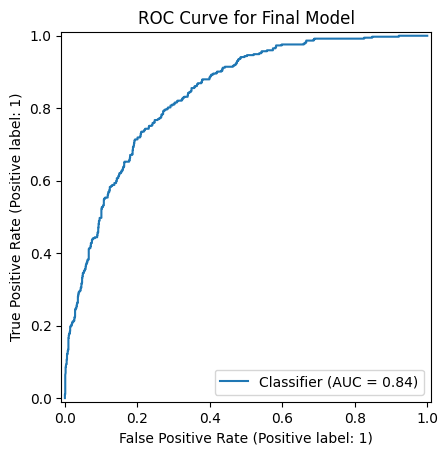

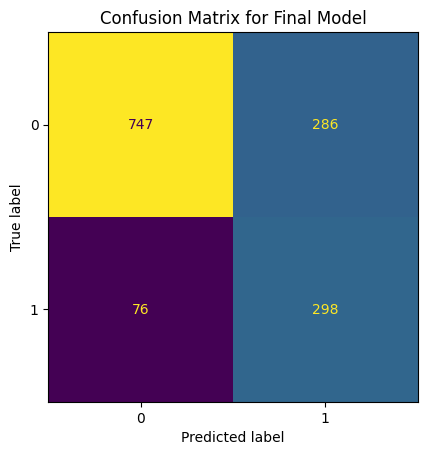


Generating and logging SHAP plot...


2025/08/17 18:00:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


SHAP plot saved and logged to MLflow.


2025/08/17 18:00:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Final model pipeline saved locally as 'retention_pulse_pipeline.pkl' and logged to MLflow.


In [38]:
# --- 8. Train and Log Final Model with MLflow ---
print("\n--- Training and Logging Final Model with MLflow ---")
mlflow.set_tracking_uri("file:../api/mlruns")  # from notebooks/ dir
mlflow.set_experiment("RetentionPulse Churn Prediction")

with mlflow.start_run() as run:
    print(f"MLflow Run ID: {run.info.run_id}")
    mlflow.log_params(study.best_params)
    
    final_model = lgb.LGBMClassifier(objective='binary', random_state=42, scale_pos_weight=scale_pos_weight, **study.best_params)
    final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', final_model)])
    final_pipeline.fit(X_train, y_train)
    
    y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]
    y_pred = final_pipeline.predict(X_test)
    final_auc_score = roc_auc_score(y_test, y_pred_proba)
    
    mlflow.log_metric("roc_auc_score", final_auc_score)
    print(f"\nFinal Model ROC AUC Score: {final_auc_score:.4f}")
    print("\nFinal Model Classification Report:")
    print(classification_report(y_test, y_pred))

    # --- 9. Add and Log Standard Visualizations ---
    print("\nGenerating and logging evaluation plots...")
    
    # ROC Curve
    fig_roc, ax_roc = plt.subplots()
    RocCurveDisplay.from_predictions(y_test, y_pred_proba, ax=ax_roc)
    ax_roc.set_title("ROC Curve for Final Model")
    mlflow.log_figure(fig_roc, "roc_curve.png")
    plt.show()

    # Confusion Matrix
    fig_cm, ax_cm = plt.subplots()
    cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax_cm, colorbar=False)
    ax_cm.set_title("Confusion Matrix for Final Model")
    mlflow.log_figure(fig_cm, "confusion_matrix.png")
    plt.show()

    # --- 10. Interpret and Log SHAP Plot ---
    print("\nGenerating and logging SHAP plot...")
    X_train_transformed = final_pipeline.named_steps['preprocessor'].transform(X_train)
    if hasattr(X_train_transformed, "toarray"):
        X_plot = X_train_transformed.toarray()
    else:
        X_plot = X_train_transformed

    explainer = shap.Explainer(final_pipeline.named_steps['classifier'])
    shap_explanation = explainer(X_plot)
    
    ohe_feature_names = final_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = list(numerical_features) + list(ohe_feature_names)

    shap_values_for_plot = shap_explanation.values
    if shap_values_for_plot.ndim == 3:
        shap_values_for_plot = shap_values_for_plot[:, :, 1]

    shap.summary_plot(shap_values_for_plot, X_plot, feature_names=all_feature_names, show=False, plot_size=(10, 8))
    fig_shap = plt.gcf()
    fig_shap.suptitle("SHAP Summary Plot for Churn Prediction", fontsize=16, y=1.02)
    fig_shap.tight_layout()
    
    shap_plot_path = "../artifacts/shap_summary.png"
    fig_shap.savefig(shap_plot_path, dpi=150, bbox_inches="tight")
    plt.close(fig_shap)
    mlflow.log_artifact(shap_plot_path)
    print(f"SHAP plot saved and logged to MLflow.")

    # --- 11. Save and Log Final Model ---
    model_path = "..models/model.pkl"
    joblib.dump(final_pipeline, model_path)
    mlflow.sklearn.log_model(final_pipeline, "model")
    print(f"\nFinal model pipeline saved locally as '{model_path}' and logged to MLflow.")



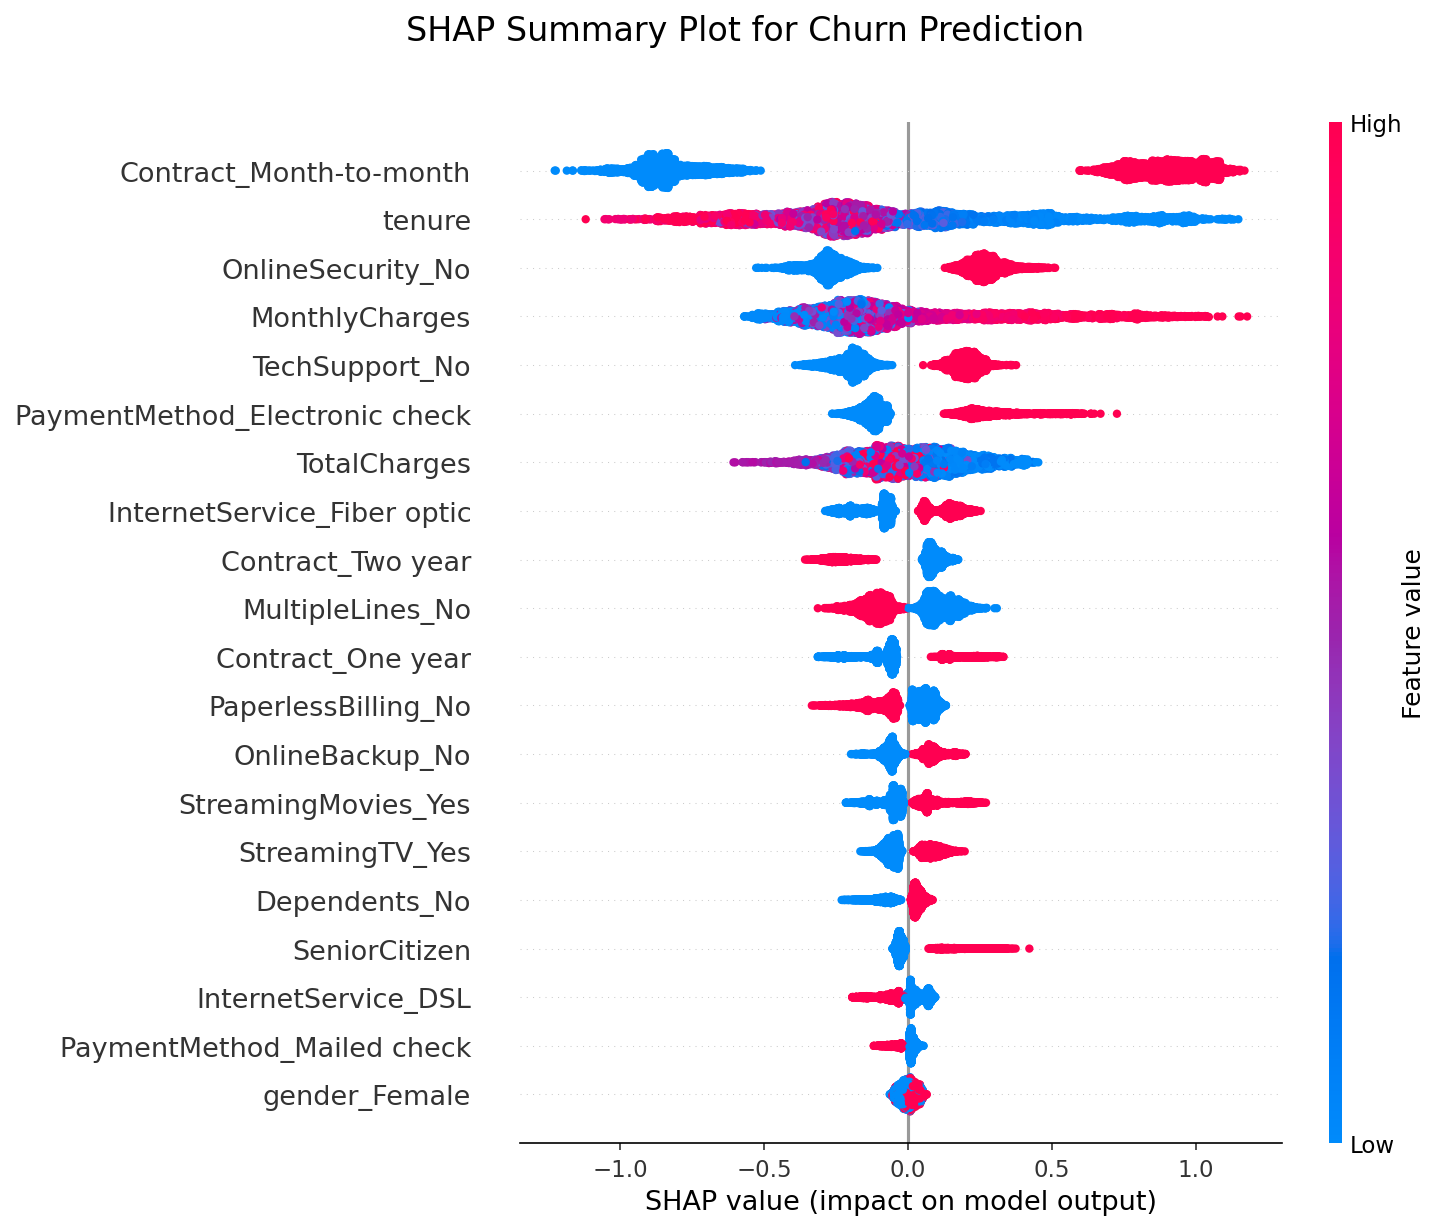

In [33]:
from IPython.display import Image, display
display(Image(filename="shap_summary.png"))


In [39]:
print("\n--- Process Complete ---")
print("To view the experiments, run 'mlflow ui' in the terminal.")


--- Process Complete ---
To view the experiments, run 'mlflow ui' in the terminal.
